# Training Neural Networks

Neural Network를 정의하고 훈련하여 MNIST 데이터 셋으로부터 손글씨 숫자를 인식하도록 훈련(train)하자.

<img src="../assets/function_approx.png" width=500px>


훈련 데이터로 신경망의 parameter (=weights,bias)를 우리가 원하는 답에 가깝게 근사하도록 해야 한다.

이러한 parameters를 찾기 위해서,loss function (=cost function)를 사용한다. 회귀문제에서 loss 함수는 mean squared loss를 사용하고 분류 문제를 위해서는 cross entropy를 주로 활용한다.

예를 들면 regression문제에서 사용되는 mean squared loss는 다음과 같다.

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

$n$ training examples의 갯수이다. $y_i$ 는 데이터의 true labels이고 $\hat{y}_i$ 는 predicted labels이다.


신경망의 학습 목표는 이러한 loss를 최소화하는 parameter를 찾는 것에 있다. 이러한 과정은 **gradient descent** 알고리즘을 활용한다. gradient 는 어떤 한점에서 loss function의 기울기를 말하고 이것은 해당 loss를 가장 빠르게 감소할수 있는 방향과 크기를 나타낸다. loss를 최소화하는 방향으로 진행하는 학습은 높은 산을 내려가는 방법과 비교할 수 있다.


<img src='../assets/gradient_descent.png' width=350px>

## Backpropagation

깊이가 깊은 multilayer neural network에서는 gradient를 계산하기 쉽지 않다. multilayer networks를 훈련하기 위한 다양한 연구가 진행되어 왔다.

backpropagation을 이해하기 쉽도록 2 layer network의 computational graph로 표현하면 다음과 같다.

<img src='../assets/backprop_diagram.png' width=550px>

forward pass는 network에서 데이터가 bottom 에서 top으로 이동하는 방향이다. 그리고 최종적으로 loss $\ell$을 계산한다. 훈련의 목적은 loss를 최소화하는 weights 와 biases 를 찾는 것이다.

gradient descent로 weight를 훈련시키기 위해, loss를 backwards로 전파한다. multilayer networks를 훈련하기 위한 방법이 **backpropagation**  이다. 궁극적으로 backpropagation은 합성함수 미분에서 chain rule를 구현하는 것이다. 

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** 

weights를 업데이트하기 위해 learning rate $\alpha$ 를 사용한다. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

learning rate $\alpha$ 은 weight를 update하는 steps을 조절하여 loss를 최소화하는 값에 수렴하도록 한다. 

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print(' Running on GPU' if tf.test.is_gpu_available() else 'GPU device not found. Running on CPU')

Using:
TensorFlow version: 2.11.0
tf.keras version: 2.11.0
GPU device not found. Running on CPU


## Load the Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
X_train = x_train / 255.0
X_test = x_test / 255.0

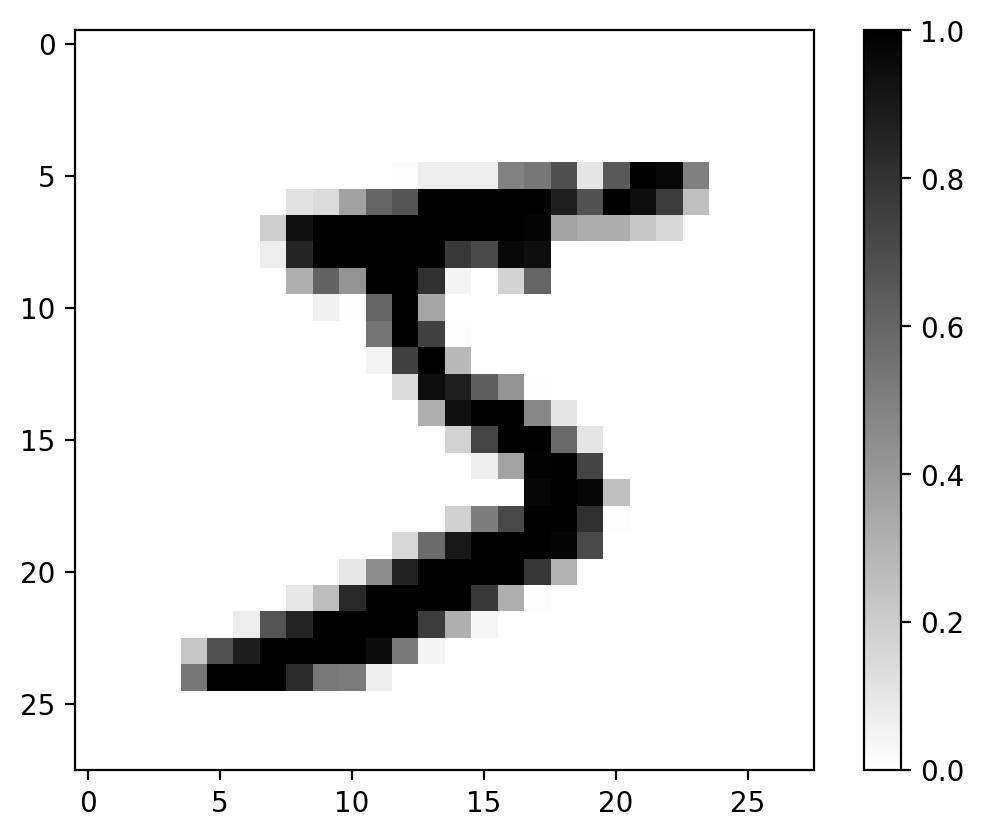

In [8]:
plt.figure()
plt.imshow(X_train[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

## Build the Model

In [9]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

# 모형의 훈련

세 가지 유형의 모형은 모두 간단한 compile 및 fit 명령어를 사용하여 컴파일 및 훈련 가능하다. 

**compile()메서드** 


* `loss = 'mse'` 에서 회귀문제를 위해 평균제곱오차를 손실함수로 설정한다.
* 다중 클래스 분류 문제를 위해서는 `categorical_crossentropy`, 이진 분류에서는 `binary_crossentropy`를 사용한다.
* `optimizer='sgd'` 경사하강법 옵티마이저를 정한다. SGD 이외에도 여러가지가 있다.

참고) https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

**fit()메서드**

* `validation_split=0.3` : 검증데이터 크기를  30%로 한다.
* `history` : 히스토리 객체는 epoch마다 계산한 손실 함수 값이 저장되어 있다. 

참고) https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

## Getting the Model Ready For Training

model을 훈련하기 위해 `.compile` method의 parameter를 설정해야 한다.


* **Optimizer:** training에서 weight를 update할 때 사용할 algorithm을 설정한다. 이 예제에서는 [`adam`](http://arxiv.org/abs/1412.6980) optimizer를 사용한다.  `tf.keras` 에서 제공하는 전체 optimizer 목록은 다음 링크를 확인한다.[optimizers documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers#classes).


* **Loss Function:**  loss function은 prediction과 실제 data의 label과의 차이를 계산한다. 이 예제에서는 `sparse_categorical_crossentropy` loss function를 사용한다. `sparse_categorical_crossentropy` loss function는 labels 이 정수인 경우에 사용한다. 그리고 `categorical_crossentropy` loss function은 one-hot encoded labels에서 사용한다. `tf.keras`에서 제공하는 loss functions 의 전체 목록은 다음 링크에서 확인한다. [losses documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses#classes).


* **Metrics:** metrics 는 모형을 훈련하는 과정에서 모형을 평가하는데 사용된다.  `accuracy`는 분류 모형의 정확도를 나타내는 지표이다. 그외의 metrics는 문서를 참조한다. [metrics documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics#classes).

그외에 사용가능한 옵션에 대해서는 텐서플로 매뉴얼 문서를 참조하여 확인한다. [TensorFlow documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#compile)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the Model

training set을 사용하여 model을 훈련한다. batch size 로 나누어 전체 데이터를 훈련하는 단위를 *epoch*이라고 한다. `.fit` method를 사용하여 정해진 epoch만큼 훈련을 수행한다.

In [21]:
EPOCHS = 5

history = model.fit(X_train,
                    y_train, 
                    epochs = EPOCHS,
                    validation_split = 0.2)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0511 - accuracy: 0.9847
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0389 - accuracy: 0.9878
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0307 - accuracy: 0.9901
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0271 - accuracy: 0.9913
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0229 - accuracy: 0.9920


`.fit` method 는 `History` object를 리턴한다. `History` object에는 훈련중에 accuracy 와 loss values를 기록한다.

훈련된 모형을 사용하여 predictions을 실행할 수 있다.

{'loss': [0.2854278087615967, 0.11838436126708984, 0.0830349251627922, 0.06262212991714478, 0.050197504460811615], 'accuracy': [0.9152500033378601, 0.9643541574478149, 0.9738541841506958, 0.9806458353996277, 0.9837499856948853], 'val_loss': [0.1461663693189621, 0.10620777308940887, 0.10300491005182266, 0.10987347364425659, 0.10231808573007584], 'val_accuracy': [0.956166684627533, 0.969083309173584, 0.9707499742507935, 0.9692500233650208, 0.971750020980835]}
--


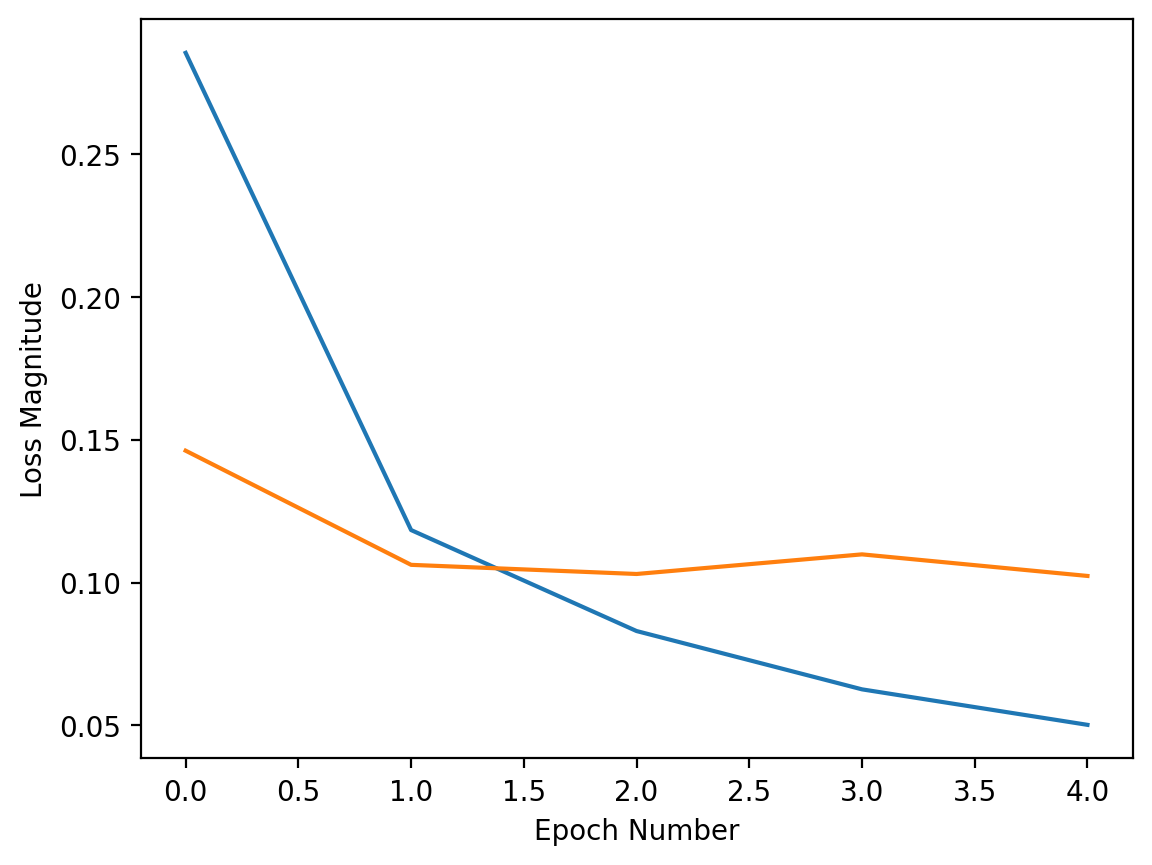

In [20]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

print(history.history)
print('--')

313/313 [==============================] - 1s 2ms/step
[[1.3574727e-06 1.5605643e-05 9.9962024e-05 ... 9.9524277e-01
  7.0229784e-05 1.0644408e-05]
 [1.4776270e-11 3.4144211e-03 9.9658525e-01 ... 5.3069221e-10
  5.4492887e-08 8.9903389e-12]
 [1.2876004e-06 9.9981171e-01 1.6223537e-05 ... 1.1177066e-04
  4.9890492e-05 1.7816744e-07]
 ...
 [4.6411650e-15 1.0288499e-09 3.7334087e-15 ... 1.2662554e-09
  4.0563652e-08 3.4269217e-08]
 [3.2077768e-11 6.7983191e-10 4.3990530e-11 ... 3.0723625e-12
  8.3883031e-05 1.2175255e-11]
 [1.6583448e-08 8.9315798e-11 2.8302722e-09 ... 7.4382740e-14
  9.8196618e-11 1.0816054e-11]]


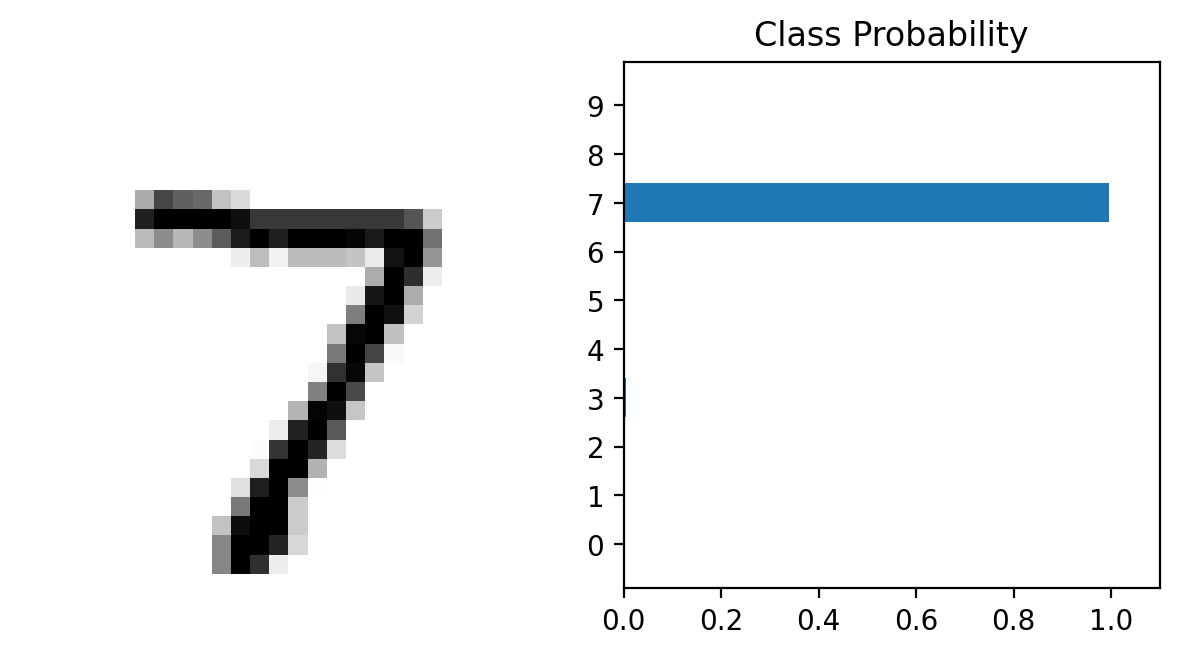

In [13]:
i = 0
ps = model.predict(X_test)
first_image = X_test.squeeze()[i]
print(ps)
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[i])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

훈련된 모형을 사용하여 다시 evaluate 해본다.

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 0.0896 - accuracy: 0.9725

Loss after training: 0.090
Accuracy after training: 97.250%


> **실습하기:** 다음과 같은 network 모형을 생성하시오. 
* input units : 784 
* 1번째 hidden layer units : 128 
* 2번째 hidden layer unit 64 
* 세번째 hidden layer units : 32 
* 마지막 output layer units : 10 . U

> 모든 hidden layer에 ReLu activation function를 사용한다. 마지막 output layer에서는 softmax activation function를 사용한다. 

> model compile에서 optimizer는 `adam` optimizer, loss 함수로는 `sparse_categorical_crossentropy` loss function를 사용하고 metric은 `accuracy`로 설정한다. 마지막으로 1개의 batch를 가져와서 훈련되지 않은 모형의 loss 와 accuracy를 화면에 출력하시오.

In [15]:
## Solution
my_model = tf.keras.Sequential([
           tf.keras.layers.Flatten(input_shape = (28,28,1)),
           tf.keras.layers.Dense(128, activation = 'relu'),
           tf.keras.layers.Dense(64, activation = 'relu'),
           tf.keras.layers.Dense(32, activation = 'relu'),
           tf.keras.layers.Dense(10, activation = 'softmax')
])


my_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


> **실습하기:** 5 epochs 으로 모형을 훈련한다. 훈련된 모형에 1개 batch를 사용하여 loss 와 accuracy를 출력해 본다.

In [16]:
EPOCHS = 5

history = my_model.fit(X_train, y_train, 
                       epochs = EPOCHS,
                       validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 3ms/step - loss: 0.2854 - accuracy: 0.9153 - val_loss: 0.1462 - val_accuracy: 0.9562
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1184 - accuracy: 0.9644 - val_loss: 0.1062 - val_accuracy: 0.9691
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0830 - accuracy: 0.9739 - val_loss: 0.1030 - val_accuracy: 0.9707
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0626 - accuracy: 0.9806 - val_loss: 0.1099 - val_accuracy: 0.9693
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0502 - accuracy: 0.9837 - val_loss: 0.1023 - val_accuracy: 0.9718


> **실습하기:** 임의의 훈련이미지로 prediction을 수행하고 각 class 에 예측 확률을 시각화하여 보시오.

313/313 [==============================] - 1s 2ms/step


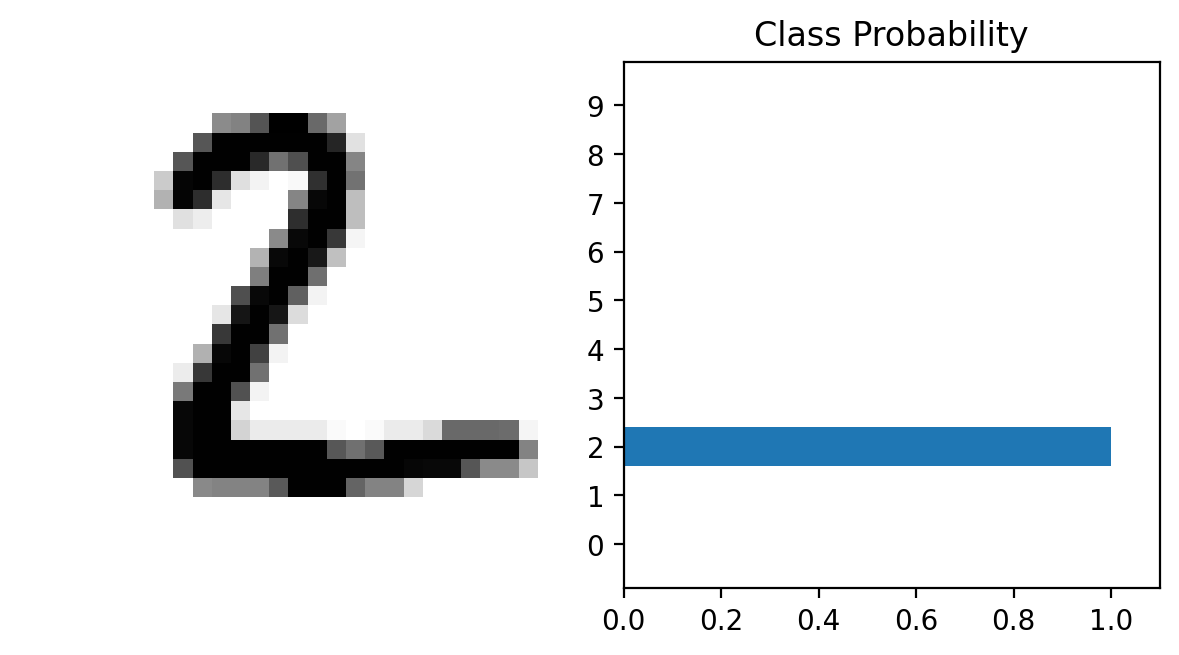

In [17]:
## Solution
i = 1
ps = my_model.predict(X_test)
first_image = X_test.squeeze()[i]
 
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[i])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()